# Planning

Business problem
- The financial institution has an estimated churn retention rate of 28%/year.
- A new retention goal was announced for next year, which is 40%. To achieve this, the customer retention team needs a churn prediction model.
- The model must be at least 55% effective in identifying true churners, while avoiding false positives.
- This way, the retention team will act using the model to reverse at least 80% of churns, which results in 44% retention, reaching the goal.

Problem type: Binary Classification
- The 'abandono_clientes.csv' dataset contains 10k rows and 13 features, which is enough to create a supervised machine learning model using a frequentist approach.
- To deal with this churn problem, some classification models will be created, and the best one will be used.

Evaluation metric: F1 score 
- F1 score will be the metric used with cross-validation, considering:
    - The business team needs a good balance between finding actual churners (recall) and avoiding false alarms (precision). 
    - The classes are unbalanced (20% of customers churned).

Methodology: CRISP-DM
- Cross Industry Standard Process for Data Mining methodology will be used, being cyclical and flexible, in order to take advantage of best market practices.

Restrictions:
- An initial project cycle will be developed, due to deadline reasons.

Project deliverables:
- EDA Notebook with:
    - Statistical analysis of data.
    - Business Insights from variables.
- Modeling Notebook with: 
    - Churn prediction model with a baseline > 0.55 (55%) on test data: 55% effectiveness in identifying true churners.
    - Model decisions explained, so retention team can understand predictions.
    - Business and Financial results of the project.
- CSV file with:
    - 'abandono_result.csv' file, being the model predictions from 'abandono_teste.csv' test dataset, with rowNumber and predictedValues columns.

# Imports

In [3]:
import pandas as pd
import numpy as np
import inflection

import seaborn as sns
from matplotlib import pyplot as plt
#import sweetviz as sv  #requires numpy downgrade (numpy==1.26.0)
import shap

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score, classification_report

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Functions

In [4]:
# Rename dataframe columns (snake_case) 
class RenameDfColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.copy().rename(columns=lambda x: inflection.underscore(x))


# Remove features from dataset
class FilterFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns if columns else []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(columns=self.columns)    


# Create new features from existing ones
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()

      # Create age_group feature
        X['age_group'] = pd.cut(
            X['age'],
            bins=[17, 30, 37, 45, 63, float('inf')], 
            labels=['18-30', '31-37', '38-45', '46-63', '64+'], 
            right=True
        )
        
        # Create geo_gender feature
        X['geo_gender'] = X['geography'] + '_' + X['gender']

        # Create balance_group feature
            # if balance = 0 or middle of distribution, then 0, else its on tail, then 1
        X['balance_group'] = X['balance'].apply(lambda x: 0 if x == 0 or (50000 <= x <= 200000) else 1)

        # Create product_group feature
        X['product_group'] = X['num_of_products'].apply(
            lambda x: 'C' if x == 2 else 'B' if x == 1 else 'A' if x in [3, 4] else None
        )

        return X

## Load Data

In [5]:
df_raw = pd.read_csv('../data/train/abandono_clientes.csv')
df_raw.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


## Data Split

In [6]:
train, test = train_test_split( df_raw, train_size=0.80, test_size=0.20, random_state=98, stratify=df_raw.Exited, shuffle=True)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

#will be used on final pipeline:
X_train_raw = train.drop('Exited', axis = 1)
y_train_raw = train.Exited 
X_test_raw = test.drop('Exited', axis = 1) 
y_test_raw = test.Exited 

print(f'Train Size: {len(train):} ({len(train)/len(df_raw):.1%})')
print(f'Test Size: {len(test):} ({len(test)/len(df_raw):.1%})')

Train Size: 8000 (80.0%)
Test Size: 2000 (20.0%)


## Data Dictionary

|  Column   | Meaning   |
| :-------  | :------- |
| **RowNumber** | Record number |
| **CustomerId** | Customer ID |
| **Surname** | Customer's last name |
| **CreditScore** | Customer's credit score |
| **Geography** | Customer's country of residence |
| **Gender** | Costumer's gender |
| **Age** | Costumer's age |
| **Tenure** | Number of years that the customer has been a client of the institution |
| **Balande** | Ammount of money the client have on it's account |
| **NumOfProducts** | Number of products that a customer has purchased through the institution |
| **HasCrCard** | Denotes whether or not a customer has a credit card with the institution. [1 - has credit card; 0 - dosen't have credit card] |
| **IsActiveMember** | Denotes whether client is active or not. [1 - active; 0 - non active ] |
| **EstimatedSalary** | Client's estimated anual salary |
| **Exited** | Denotes whether the client has an account at the institution. [1 - Client has exited instittion; 0 - client dosen't have exited institution] |

# Data Cleaning

## Rename Features

In [7]:
#Rename columns (snake_case) with Pipeline 
pipe_rename_features = Pipeline([
    ('rename_features', RenameDfColumns())
])
train = pipe_rename_features.fit_transform(train)
train.head(2)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,2603,15683521,Godfrey,594,Germany,Male,28,0,142574.71,2,1,0,129084.82,0
1,4606,15585599,Stone,530,France,Female,34,8,0.00,2,0,1,141872.52,0


## DTypes and Missings

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        8000 non-null   int64  
 1   customer_id       8000 non-null   int64  
 2   surname           8000 non-null   object 
 3   credit_score      8000 non-null   int64  
 4   geography         8000 non-null   object 
 5   gender            8000 non-null   object 
 6   age               8000 non-null   int64  
 7   tenure            8000 non-null   int64  
 8   balance           8000 non-null   float64
 9   num_of_products   8000 non-null   int64  
 10  has_cr_card       8000 non-null   int64  
 11  is_active_member  8000 non-null   int64  
 12  estimated_salary  8000 non-null   float64
 13  exited            8000 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 875.1+ KB


No missings, dtypes ok.

## Duplicates

In [9]:
# Get duplicate rows
train[train.duplicated()]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No duplicated rows.

## Feature Filtering

Remove unnecessary features:

In [10]:
# Remove features with Pipeline
pipe_filter_features = Pipeline([
    ('filter_features', FilterFeatures(columns=['row_number', 'customer_id', 'surname']))
])

# Filter Columns using Pipeline
train = pipe_filter_features.transform(train)
train[:1]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,594,Germany,Male,28,0,142574.71,2,1,0,129084.82,0


# Feature Engineering

In [10]:
# Split data from train and test
X_train = train.drop('exited', axis = 1) # will be used to check pipeline parts
X_test = test.drop('Exited', axis = 1)
y_train = train['exited']
y_test = test['Exited']
del train, test

Based on EDA, these are the initial feature engineering ideas to improve model performance:
- Cross gender vs geography (all vs all).
- Create age groups from age, like: 18-30, 31-45, 46-65, 66+, calibrating to make them balanced.
- Create a binary indicator for balance: center vs tail (tail: except customers with a balance = 0, those with less than 50k and with more than 200k churned more vs rest).
- Create a scale for num_of_product: "C" for 2 products, "B" for 1 product, "A" for 3 or 4 products (3 groups).

They will be implemented through the FeatureEngineering class below.

In [11]:
# Before feature engineering
X_train[:1]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
0,594,Germany,Male,28,0,142574.71,2,1,0,129084.82


In [12]:
# Feature Engineering with Pipeline
pipe_feature_eng = Pipeline([
    ('feature_eng', FeatureEngineering())
])

X_train = pipe_feature_eng.fit_transform(X_train)
X_train[:2]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,age_group,geo_gender,balance_group,product_group
0,594,Germany,Male,28,0,142574.71,2,1,0,129084.82,18-30,Germany_Male,0,C
1,530,France,Female,34,8,0.00,2,0,1,141872.52,31-37,France_Female,0,C


# Data Preparation

Feature Scaling and Transformation will be applied to the dataset, to avoid biased results, accelerate training, and improve interpretability. 
- Feature Scaling: makes numerical features comparable, preventing dominance of larger-scale features, and iproves model convergence.
- Transformation: handles categorical data, fixes non-linear relationships and reduces data skewness.

In [14]:
#X_train_bk1 = X_train.copy()
#X_train = X_train_bk1.copy()

In [15]:
X_train[:1]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,age_group,geo_gender,balance_group,product_group
0,594,Germany,Male,28,0,142574.71,2,1,0,129084.82,18-30,Germany_Male,0,C


## Feature Scaling

In [16]:
# Select numerical features 
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])
X_train_num[:2]

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,balance_group
0,594,28,0,142574.71,2,1,0,129084.82,0
1,530,34,8,0.00,2,0,1,141872.52,0


Perform Shapiro-Wilk test on numerical features, to identify which are normally distributed.

In [17]:
print(f' Normal distribution: (True/False)') 
for feature in list(X_train_num.columns):
    sample_data = X_train_num[feature].sample(n=5000, random_state=42)
    stat, p = shapiro(sample_data)
    print(f' -{feature} --> {p > 0.05}')

 Normal distribution: (True/False)
 -credit_score --> False
 -age --> False
 -tenure --> False
 -balance --> False
 -num_of_products --> False
 -has_cr_card --> False
 -is_active_member --> False
 -estimated_salary --> False
 -balance_group --> False


Since features are not normally distributed, I will use MinMaxScaler.

In [18]:
# MinMaxScaler with Pipeline
pipe_numeric_scaling = Pipeline([
    ('numeric_scaling', MinMaxScaler())
])

## Transformations

In [19]:
#Select categorical features 
X_train_cat = X_train.select_dtypes(exclude=['int64', 'float64'])
X_train_cat[:2]

,geography,gender,age_group,geo_gender,product_group
0,Germany,Male,18-30,Germany_Male,C
1,France,Female,31-37,France_Female,C


Categorical feature have few variations, so I will use One Hot Encoding. It preserves all category information, and benefits model interpretability. 

In [24]:
# OneHotEncoder with Pipeline
pipe_categ_transform = Pipeline([
    ('categ_transform', OneHotEncoder(sparse_output=False)) 
])

In [25]:
#X_train_bk2 = X_train.copy()
#X_train = X_train_bk2.copy()

In [26]:
# Before data preparation:
X_train[:2]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,age_group,geo_gender,balance_group,product_group
0,594,Germany,Male,28,0,142574.71,2,1,0,129084.82,18-30,Germany_Male,0,C
1,530,France,Female,34,8,0.00,2,0,1,141872.52,31-37,France_Female,0,C


In [27]:
X_train_num_cols = X_train_num.select_dtypes(include=['int64', 'float64']).columns
X_train_cat_cols = X_train_cat.select_dtypes(exclude=['int64', 'float64']).columns

# Preprocessing ColumnTransformer, mixing both: 
col_transformer_dt_prep = ColumnTransformer(
    transformers=[
        ('num', pipe_numeric_scaling, X_train_num_cols),
        ('cat', pipe_categ_transform, X_train_cat_cols),
    ]
)

# Apply data preparation to inspect data
X_train = col_transformer_dt_prep.fit_transform(X_train)
X_train[:1]

array([[0.488     , 0.13513514, 0.        , 0.56825745, 0.33333333,
        1.        , 0.        , 0.64528862, 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        ]])

In [30]:
# Transform X_train array numpy into DataFrame. Get feature names from the fitted ColumnTransformer
transformed_columns = []
for name, transformer, columns in col_transformer_dt_prep.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        transformed_columns.extend(transformer.get_feature_names_out(columns)) # For transformers that create new features (like OneHotEncoder)
    else:
        transformed_columns.extend(columns) # For transformers that keep original features (like scalers)
X_train = pd.DataFrame(X_train, columns=transformed_columns)
print(X_train.shape)
X_train[:1]

(8000, 28)


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,balance_group,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male,age_group_18-30,age_group_31-37,age_group_38-45,age_group_46-63,age_group_64+,geo_gender_France_Female,geo_gender_France_Male,geo_gender_Germany_Female,geo_gender_Germany_Male,geo_gender_Spain_Female,geo_gender_Spain_Male,product_group_A,product_group_B,product_group_C
0,0.49,0.14,0.00,0.57,0.33,1.00,0.00,0.65,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


# Feature Selection

To keep just the best features among all, an ExtraTreesClassifier will be used to rank features by importance.

This reduces model complexity, improves model performance, and makes ir more interpretable.

The ExtraTreesClassifier builds 50 random decision trees, and each tree votes on which features are important, so the average importance of each feature is calculated.

Selected features will be those with above 30% of the mean importance ("0.3*mean").

In [31]:
pipe_feat_selection = Pipeline([
    ('feat_selection', SelectFromModel(
        estimator=ExtraTreesClassifier(n_estimators=50, random_state=98), 
        threshold= "0.3*mean"              
    ))
])

Select and plot features by importance:

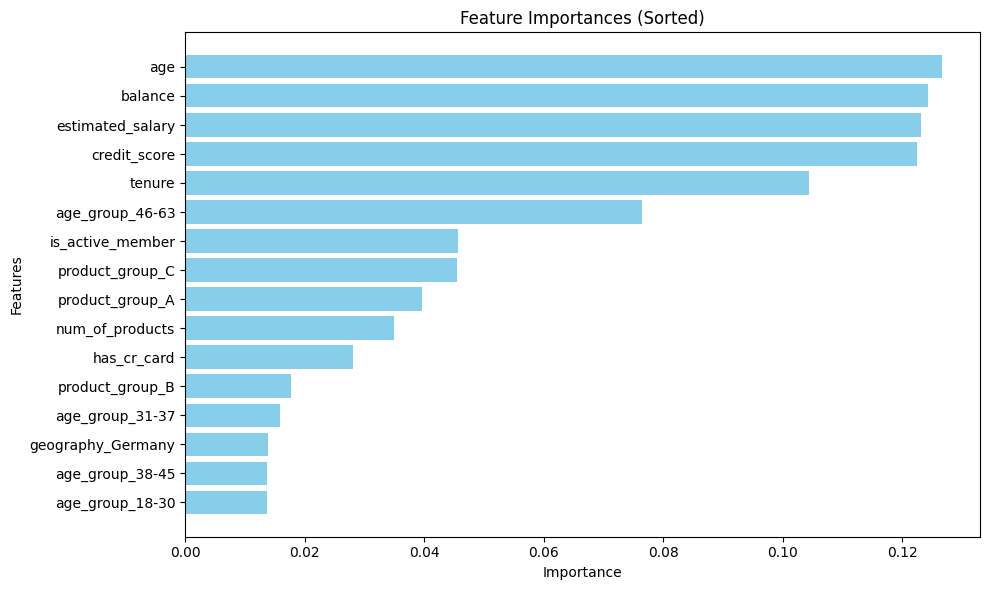

In [32]:
pipe_feat_selection.fit(X_train, y_train)
selector = pipe_feat_selection.named_steps['feat_selection']
feature_names = X_train.columns

def plot_feature_importances(selector, feature_names):
    importances = selector.estimator_.feature_importances_
    selected_features = selector.get_support()
    selected_importances = importances[selected_features]
    selected_names = np.array(feature_names)[selected_features]
    sorted_indices = selected_importances.argsort()[::-1]
    sorted_importances = selected_importances[sorted_indices]
    sorted_names = selected_names[sorted_indices]
    
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_names, sorted_importances, color='skyblue')
    plt.gca().invert_yaxis()  # Add this line to invert y-axis
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importances (Sorted)')
    plt.tight_layout()
    plt.show()

plot_feature_importances(selector, feature_names)

In [33]:
#Extract feature importances from selector and save in a list of feature names in order of importance 
importances = selector.estimator_.feature_importances_
selected_features = selector.get_support()
selected_importances = importances[selected_features]
selected_names = np.array(feature_names)[selected_features]
sorted_indices = selected_importances.argsort()[::-1]
sorted_names = selected_names[sorted_indices]
features_selected_ordered_list = sorted_names.tolist()
features_selected_ordered_list

['age',
 'balance',
 'estimated_salary',
 'credit_score',
 'tenure',
 'age_group_46-63',
 'is_active_member',
 'product_group_C',
 'product_group_A',
 'num_of_products',
 'has_cr_card',
 'product_group_B',
 'age_group_31-37',
 'geography_Germany',
 'age_group_38-45',
 'age_group_18-30']

In [34]:
#Inspect features selected, before Modelling:
X_train[features_selected_ordered_list][:1]

,age,balance,estimated_salary,credit_score,tenure,age_group_46-63,is_active_member,product_group_C,product_group_A,num_of_products,has_cr_card,product_group_B,age_group_31-37,geography_Germany,age_group_38-45,age_group_18-30
0,0.14,0.57,0.65,0.49,0.00,0.00,0.00,1.00,0.00,0.33,1.00,0.00,0.00,1.00,0.00,1.00


In [35]:
# Apply feature selection with pipeline (creates a np array)
X_train = pipe_feat_selection.transform(X_train)

In [36]:
X_train[:1]

array([[0.488     , 0.13513514, 0.        , 0.56825745, 0.33333333,
        1.        , 0.        , 0.64528862, 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        ]])

# Machine Learning

## BayesSearchCV

BayesSearchCV will be used to evaluate different ML models with Cross Validation.

It uses Bayesian Optimization to find the best hyperparameters, through Exploration vs Exploitation:
- Exploration: Trying new areas of the parameter space.
- Exploitation: Focusing on areas known to give good results.

### Class balancing

Target variable classes are unbalanced. 

Models will have more difficulty getting class 1 right. So to compensate this, a greater weight will be given to this class 1 (churn).

This way, the models meet business team needs: a strong balance between finding actual churners (recall) and avoiding false alarms (precision).

In [37]:
# Calculate scale_pos_weight (class balancing)
calc_spweight = (y_train == 0).sum() / (y_train == 1).sum()

# Manual calibration to improve f1_score (classification report)
calc_spweight = 2
print(f'scale_pos_weight: {(round(calc_spweight,1))}')

scale_pos_weight: 2


### Machine Learning Models

ML models with different approaches will be tried:
- Linear Discriminant Analysis (LDA): linear classifier, similar to Logistic Regression. It can handle class imbalance through prior probabilities adjustment. It is widely used supervised algorithms for churn prediction.
- RandomForest approach: builds multiple decision trees in parallel independently.
- XGBoost approach: builds trees sequentially, with each new tree correcting errors from previous ones. Better handles class imbalance than RF, but it is more computationally intensive.

In [38]:
lda = LinearDiscriminantAnalysis(solver='lsqr', priors=[0.8, calc_spweight/10])  # 'lsqr': Supports shrinkage, good for high-dimensional data
rf = RandomForestClassifier(n_jobs=-1, random_state=98, class_weight={0:1, 1:calc_spweight})
xgb = XGBClassifier(n_jobs=-1, random_state=98, scale_pos_weight=calc_spweight)

### Hyperparameter Tuning

A hyperparameter space was created for each model, and will be used by BayesSearchCV for the exploration/exploitation process.

In [39]:
params_grid = [    
    
    {# LinearDiscriminantAnalysis params
        'classifier': [lda],
        'classifier__shrinkage': Real(0.0, 1.0),     # Similar to regularization
        'classifier__tol': Real(1e-5, 1e-3),         # Threshold for rank estimation
    },
    
    {# RandomForestClassifier params
        'classifier': [rf],
        'classifier__n_estimators': Integer(10, 500),              # Number of trees in the forest
        'classifier__max_features': Categorical([2, 3, 4]),        # Max features to consider for split
        'classifier__max_depth': Integer(2, 11),                   # Maximum depth of each tree
        'classifier__min_samples_split': Categorical([2, 5, 10]),  # Min samples required to split
        'classifier__min_samples_leaf': Categorical([1, 2, 4]),    # Min samples in leaf node
        'classifier__max_leaf_nodes': Categorical([5, 10, 15])     # Max number of leaf nodes
    },
    
    {# XGBoost params
        'classifier': [xgb],
        'classifier__n_estimators': Integer(10, 500),              # Number of boosting rounds
        'classifier__max_depth': Integer(2, 11),                   # Maximum depth of trees
        'classifier__min_child_weight': Categorical([1, 3, 5]),    # Min sum of weights needed in child
        'classifier__subsample': Real(0.6, 1.0),                   # Fraction of samples used for tree building
        'classifier__colsample_bytree': Real(0.6, 1.0),            # Fraction of features used per tree
    }
]

In [40]:
# Create pipeline for machine learning models. Will consider all of them.
pipe_ml_models = Pipeline([
    ('classifier', RandomForestClassifier(n_jobs=-1, random_state=98))
])

In [41]:
# Instanciate BayesSearchCV
bs_cv_best_model = BayesSearchCV(
    pipe_ml_models,
    search_spaces=params_grid,
    n_iter = 15,   # Number of parameter settings that are sampled - default=50  -> n_iter trades off runtime (less) vs quality of the solution (more).
    n_points = 2,  # Number of parameter settings to sample in parallel. default=1
    cv = 10,       # Evaluations: [ n_iter * n_points * CV] 
    scoring='f1',
    random_state=98,
    return_train_score=True, # Will be used to identify possible overfitting
    n_jobs=-1,
    verbose = 2
)

# Fit, looking for the best model
bs_cv_best_model.fit(X_train, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\norton\repos\bank_churn_prediction\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits


C:\Users\norton\repos\bank_churn_prediction\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits


C:\Users\norton\repos\bank_churn_prediction\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


BayesSearchCV(cv=10,
              estimator=Pipeline(steps=[('classifier',
                                         RandomForestClassifier(n_jobs=-1,
                                                                random_state=98))]),
              n_iter=15, n_jobs=-1, n_points=2, random_state=98,
              return_train_score=True, scoring='f1',
              search_spaces=[{'classifier': [LinearDiscriminantAnalysis(priors=[0.8,
                                                                                0.2],
                                                                        solver='lsqr')],
                              'classifier__shrinkage': Real(low=0.0, high=1.0, prior='uniform', t...
                              'classifier__colsample_bytree': Real(low=0.6, high=1.0, prior='uniform', transform='normalize'),
                              'classifier__max_depth': Integer(low=2, high=11, prior='uniform', transform='normalize'),
                              'classifier__min_child_weight': Categorical(categories=(1, 3, 5), prior=None),
                              'classifier__n_estimators': Integer(low=10, high=500, prior='uniform', transform='normalize'),
                              'classifier__subsample': Real(low=0.6, high=1.0, prior='uniform', transform='normalize')}],
              verbose=2)

### Evaluation Metric

F1 score will be the metric used, considering:
- The business team needs a strong balance between finding actual churners (recall) and avoiding false alarms (precision). f1_score resumes precision and recall, being the harmonic mean between them.
- The classes are unbalanced (20% of customers churned).

In [44]:
# Check top 3 models, with its parameters, and mean train vs validation score
res_bs_cv_best_model = pd.DataFrame(bs_cv_best_model.cv_results_)
res_bs_cv_best_model[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:3]

,rank_test_score,params,mean_train_score,mean_test_score
39,1,"{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=-1, num_parallel_tree=None, random_state=98, ...), 'classifier__colsample_bytree': 0.6127076182833742, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 52, 'classifier__subsample': 0.6965079741065412}",0.67,0.62
42,2,"{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=-1, num_parallel_tree=None, random_state=98, ...), 'classifier__colsample_bytree': 0.6, 'classifier__max_depth': 2, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 417, 'classifier__subsample': 0.6}",0.70,0.61
41,3,"{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=-1, num_parallel_tree=None, random_state=98, ...), 'classifier__colsample_bytree': 0.675696397448567, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 10, 'classifier__subsample': 1.0}",0.62,0.61


In [45]:
print(f"Best model and params: \n  {bs_cv_best_model.best_estimator_}\n ")
print(f"Best cross-val score with f1_score: {bs_cv_best_model.best_score_:.2f}")

Best model and params: 
  Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6127076182833742, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estima

By default, when using f1 as the scoring parameter in GridSearchCV for binary classification, it calculates the F1 score for the positive class (class 1).

The classification_report shows the f1_score for both classes.

In [46]:
# Generate predictions with X_train
y_pred_train = bs_cv_best_model.predict(X_train)

print('\nClassification Report:')
print(classification_report(y_train, y_pred_train))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      6370
           1       0.67      0.66      0.66      1630

    accuracy                           0.86      8000
   macro avg       0.79      0.79      0.79      8000
weighted avg       0.86      0.86      0.86      8000



### Train Model Performance

Class 1 (Churners) --> f1-score = 0.66

Interpretation:

    - Model has 66% effectiveness in identifying true churners.
    - There is a balance between finding actual churners (recall) and not raising false alarms (precision).

Class 0 (Non-churners) --> f1-score = 0.91

Interpretation:

    - Model has 91% effectiveness in identifying non-churners (loyal customers)
    - There is also a balance between finding actual churners (recall) and not raising false alarms (precision).

On next cycles, to improve the f1_score of class 1:
- New feature engineering can be done, to introduce stronger features that better distinguish class 1.
- Different stratyegies to give more weight to class 1 can be tried.
- New feature selection techniques or thresholds can be tried, to identify the most discriminative features.

## Model Explainability

The model predictions will be explained to business team with SHAP (SHapley Additive exPlanations).

Shap explains:
- Which features matter most
- How features affect predictions

In [76]:
# Recreate DataFrame with features selected on feature selection
X_train_feat_sel = pd.DataFrame(X_train, columns=features_selected_ordered_list)

# Get the best estimator from BayesSearchCV
best_estimator = bs_cv_best_model.best_estimator_.named_steps['classifier']

# Instantiate Shap, load the estimator, and the dataset
s = shap.TreeExplainer(best_estimator)
shap_vals = s.shap_values(X_train_feat_sel)
target_idx = 1 # 1, so right side = churn

### Summary plot

The SHAP summary plot shows how each feature impacts model predictions:

- Each dot represents one observation.
- Features are ranked by importance (top to bottom). 
    - Higher position = more important feature.
    - Longer bars = stronger overall impact

Color Interpretation:
- Red dots: High feature values. Blue dots: Low feature values

Impact Direction:
- If red dots are on right (positive SHAP): High values increase churn probability
- If blue dots are on right (negative SHAP): Low values increase churn probability

Exemple of Churn Interpretation:
- balance: customers with higher balance values have higher churn probability (most of red dots are on right)
- age_group_18-30: customers not within this age group have higher churn probability (all blue dots are on right)
- is_active_member: customers who are not active memers have higher churn probability (all blue dots are on right)
- product_group_A: customers on group A (they have 3 or 4 products) have higher churn probability (most of red dots are on right)

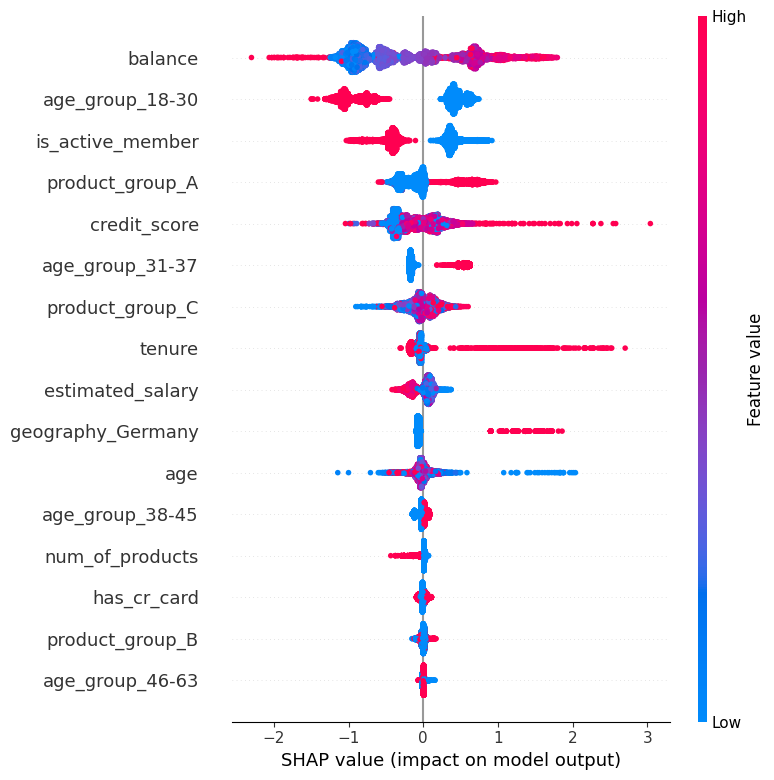

In [75]:
shap.initjs()
shap_vals = s.shap_values(X_train_feat_sel)
shap.summary_plot(shap_vals, X_train_feat_sel)

### Individual Predictions

Inspect first customer of train dataset. 

1 - What was the model prediction? (0= no churn, 1= churn)

In [96]:
# Model prediction
print(f"Model prediction for first customer is: {best_estimator.predict(X_train_feat_sel.iloc[:1])[0] }")

Model prediction for first customer is: 0


2 - What is this customer probability of churn?

In [97]:
print(f"Churn probability for first customer: {round(best_estimator.predict_proba(X_train_feat_sel.iloc[[0]])[0][1] * 100)}%")

Churn probability for first customer: 7%


3 - How this prediction was calculated by the model?

Individual Plot:
- The middle number (base value) shows the average/base prediction for all customers.

Features are arrows. Arrow length: Magnitude of impact.
- Red arrows: Push prediction toward churn (1)
- Blue arrows: Push prediction away from churn (0)

Exemple of Churn Interpretation for this customer:

--> few features contributing to push toward churn. The main is:
  - product_group_A: customers on group A (they have 3 or 4 products) have higher churn probability.

--> more features pushing predictions away from churn. The 2 main are (with more intensity): 
  - balance: customers with low balance values have lower churn probability
  - age_group_18-30: customers within this age group have lower churn probability

In [98]:
shap.initjs()
shap_vals_1 = s.shap_values(X_train_feat_sel[:1])
shap.force_plot(s.expected_value, shap_vals_1,feature_names=X_train_feat_sel.columns)

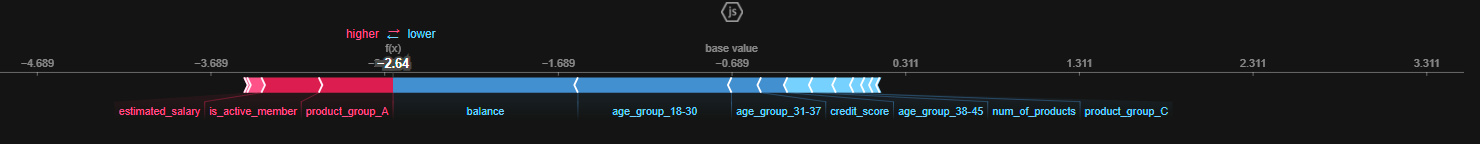

## Pipeline with best model

The best model evaluated was an XGBoostClassifier.

Pros:
- Handles non-linear relationships between features naturally.
- Better at handling imbalanced datasets compared to basic algorithms (scale_pos_weight parameter).
- Offers multiple hyperparameters for fine-tuning.

Cons:
- Performance deteriorates with highly imbalanced datasets (especially < 5% minority class, which is not the case)
- Requires a more attentive hyperparameter tuning
- Works best with larger datasets than this (8k rows)

A new pipeline will be built now with the XGBoostClassifier.

It will read the raw train dataset, and apply all steps done separately up to the machine learning step.

In [114]:
# Create f1 metric, since Xgboost does not handles nativelly with it
def f1_metric_(predt, dtrain):
    y_true = dtrain.get_label()
    y_pred = (predt > 0.5).astype(int)
    return 'f1', f1_score(y_true, y_pred)

In [124]:
#Train a new XGBClassifier with same parameters of best model 
best_model = XGBClassifier(
    max_depth=3,
    n_estimators=52,
    n_jobs=-1,
    colsample_bytree= 0.6127076182833742,
    min_child_weight= 1,
    subsample= 0.6965079741065412,
    random_state=98,
    eval_metric=f1_metric_
)

In [128]:
# Full Training Pipeline
pipe_train = Pipeline([
    # Rename Columns
    ('rename_features', RenameDfColumns()),
    # Filter Features
    ('filter_features', FilterFeatures(columns=['row_number', 'customer_id', 'surname'])),
    # # Feature engineering
    ('feature_eng', FeatureEngineering()),
    # Data Preparation
    ('preprocessing', col_transformer_dt_prep), 
    # # Feature Selection
    ('feat_selection', pipe_feat_selection),
    # # Model Training
    ('train_classifier', best_model)           
])
#pipe_train

In [129]:
#Use X_train_raw, not touched, splitted in Data Split
print(X_train_raw.shape)
X_train_raw[:1]

(8000, 13)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,2603,15683521,Godfrey,594,Germany,Male,28,0,142574.71,2,1,0,129084.82


In [130]:
# Fit pipeline
model_pipe_trained = pipe_train.fit(X_train_raw, y_train)
model_pipe_trained

Pipeline(steps=[('rename_features', RenameDfColumns()),
                ('filter_features',
                 FilterFeatures(columns=['row_number', 'customer_id',
                                         'surname'])),
                ('feature_eng', FeatureEngineering()),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric_scaling',
                                                                   MinMaxScaler())]),
                                                  Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'h...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=52, n_jobs=-1,
                               num_parallel_tree=None, random_state=98, ...))])

Make predictions on train data:

In [131]:
y_pred_train = model_pipe_trained.predict(X_train_raw)
f1_train = f1_score(y_train_raw, y_pred_train)

print(f'F1 score on Train Data: {f1_train:.2f}')

F1 score on Train Data: 0.62


Ok, performance was same as when choosing best model.

Make predictions on test data, simulating production data.

Use X_test_raw, not touched, splitted in Data Split:

In [134]:
y_pred_test = model_pipe_trained.predict(X_test_raw)

# Calculate F1 score
f1_test = f1_score(y_test_raw, y_pred_test)
print(f'F1 score on Test Data: {f1_test:.2f}')

F1 score on Test Data: 0.57


In [135]:
# Get detailed classification metrics
print('\nDetailed Classification Report:')
print(classification_report(y_test_raw, y_pred_test))


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1593
           1       0.77      0.46      0.57       407

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000



Considerations:
- There is a slight overfitting on test data (Difference: 0.05), 
- This can be addressed on cycle 2, reducing model complexity (tree depth in tree-based models).

## Final Model Performance

Performance considering test data.

Class 1 (Churners) --> f1-score = 0.57

Interpretation:

    - Model has 57% effectiveness in identifying true churners.
    - The balance between finding actual churners (recall) and not raising false alarms (precision) for class 1 (churn), needs improvement on cycle 2.

Class 0 (Non-churners) --> f1-score = 0.92

Interpretation:

    - Model has 92% effectiveness in identifying non-churners (loyal customers)
    - There is a balance between finding actual churners (recall) and not raising false alarms (precision).

## Retrain With All Data

The final model was trained using 8k rows, because 2k rows were user as test.

Now, a final model with 10k row will be trained. It has the same parameters as the best one.

The objective is to improve performance for final prediction.


In [140]:
#Use df_raw, not touched, loaded in Load Data section:
print(df_raw.shape)
df_raw.head(1)

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1


In [141]:
# Retrain a new XGBClassifier with 10k rows now, with same parameters of best model 
best_model_full = XGBClassifier(
    max_depth=3,
    n_estimators=52,
    n_jobs=-1,
    colsample_bytree= 0.6127076182833742,
    min_child_weight= 1,
    subsample= 0.6965079741065412,
    random_state=98,
    eval_metric=f1_metric_
)

# Final Pipeline
pipe_full = Pipeline([
    # Rename Columns
    ('rename_features', RenameDfColumns()),
    # Filter Features
    ('filter_features', FilterFeatures(columns=['row_number', 'customer_id', 'surname'])),
    # # Feature engineering
    ('feature_eng', FeatureEngineering()),
    # Data Preparation
    ('preprocessing', col_transformer_dt_prep), 
    # # Feature Selection
    ('feat_selection', pipe_feat_selection),
    # # Model Training
    ('train_classifier', best_model_full)           
])

X_full = df_raw.drop('Exited', axis=1)
y_full = df_raw.Exited

# Fit Final Pipeline
model_full = pipe_full.fit(X_full, y_full)
model_full

Pipeline(steps=[('rename_features', RenameDfColumns()),
                ('filter_features',
                 FilterFeatures(columns=['row_number', 'customer_id',
                                         'surname'])),
                ('feature_eng', FeatureEngineering()),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric_scaling',
                                                                   MinMaxScaler())]),
                                                  Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'h...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=52, n_jobs=-1,
                               num_parallel_tree=None, random_state=98, ...))])

In [143]:
y_pred_full = model_full.predict(X_full)
f1_full = f1_score(y_full, y_pred_full)
print(f'F1 score on Full Dataset: {f1_full:.2f}')

F1 score on Full Dataset: 0.62


Metric similar to the one with best model pipeline one.

## Final Predictions

Load test data, predict churn and export file with predictions.  

In [144]:
df_ans = pd.read_csv('../data/test/abandono_teste.csv', sep=';')
print(df_ans.shape)
df_ans.head(1)

(1000, 13)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,10001,15798485,Copley,565,France,Male,31,1,0.00,1,0,1,20443.08


In [145]:
# Predict
y_pred_full = model_full.predict(df_ans)

# Create final file
df_ans_final = pd.DataFrame({ 'rowNumber': df_ans['RowNumber'], 'predictedValues': y_pred_full})
print(df_ans_final.shape)
df_ans_final.head(2)

(1000, 2)


,rowNumber,predictedValues
0,10001,0
1,10002,0


In [146]:
# Inspect class proportion of predictions
df_ans_final.predictedValues.value_counts(normalize=True)

predictedValues
0   0.85
1   0.14
Name: proportion, dtype: float64

In [147]:
# Export predictions to CSV
df_ans_final.to_csv('../data/result/abandono_result.csv', index=False)

# Business and Financial Results

## Busness Results

Here, the business results of this project will be shown.

Business problem: 
- The financial institution has an estimated churn retention rate of 28%/year.
- A new retention goal was announced for next year, which is 40%. To achieve this, the customer retention team needs a churn prediction model.
- The model must be at least 55% effective in identifying true churners, while avoiding false positives.
- This way, the retention team will act using the model to reverse at least 80% of churns, which results in 44% retention, reaching the goal.

Business results:
- The fraud prediction model in it's first cycle delivers 57% effective in identifying true churners.
- The result expected by retention team was a model with at least 55% effectiveness, wich was attained.
- Now the project can be put into production, and the retention team can then start using it, working towards achieving the new retention goal of $40 for next year.

## Financial Results

Here, the financial results of this churn prediction model will be estimated.

Premisses:
- Model effectiveness (F1-score) is 0.57.
- Company has a base of 10 million customers.
- Average estimated cost per churned customer: R$ 750 / year.
- Average estimated churn rate: 18% / year -> 1.800.000 customers/year.

Current 1 year scenario without the model:
- Estimated churn company's retention rate: 28% / year.
- Estimated churn cost: RS 972.000.000/year (72% of 1.800.000 customers * RS 750)

Current 1 year scenario using the model:
- Estimated churn company's retention rate: 46% / year (model identifies 57%, and 80% is retained). 
- Estimated churn cost: RS 729.000.000/year (54% of 1.800.000 customers * RS 750)

Estimated Savings using the model: RS 243.000.000/year.
Considering the model is on cycle 1, and there is a lot of opportunity to improve it, the result can be even greater in the future.

# Improvements for Next Cycles

- Improve the balance between finding actual churners (recall) and not raising false alarms (precision) for class 1 (churn).
- Solve the slight overfitting on test data (Difference: 0.05), reducing model complexity (tree depth in tree-based models).
- New feature selection techniques or thresholds can be tried, to identify the most discriminative features.
- Test and remove highly correlated variables, reducing collinearity.
- Running a clustering after EDA, to identify natural groups of customers, and label them as new features. Also, to identify differnt risk profiles, and provide business with different retention approaches per cluster.
- Increase the number of derived features in feature engineering by crossing features with each other, and trying interactions and polynomials.